## Connect to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 20 23:50:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    28W /  70W |  13193MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Connect to GPU

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
tf.debugging.set_log_device_placement(True)

# Create some tensors

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Run on the GPU
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
tf.debugging.set_log_device_placement(True)

## Import Libraries

In [ ]:
!pip install tensorflow-addons==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load datasets with ImageDataGenerator

In [ ]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

Variables Initialization

In [ ]:
# data (img)
img_height = 256
img_width = 256
channels = 3

#training
epoch = 0 # epoch to start training from
n_epochs = 3 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 2# suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay
checkpoint_interval = -1
# number of residual blocks in generator
n_residual_blocks = 9
# cycle loss weight
lambda_cyc = 10.0
# identity loss weight
lambda_id = 5.0
# Development / Debug Mode
debug_mode = False

In [ ]:
"""class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
                ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]

        # Unpacking
        self.model = nn.Sequential(*model)

    def forward(self, x):
      return self.model(x)"""

'class ResidualBlock(nn.Module):\n    def __init__(self, in_features):\n        super(ResidualBlock, self).__init__()\n\n        self.block = nn.Sequential(\n            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary\n            nn.Conv2d(in_features, in_features, 3),\n            nn.InstanceNorm2d(in_features),\n            nn.ReLU(inplace=True),\n            nn.ReflectionPad2d(1),\n            nn.Conv2d(in_features, in_features, 3),\n            nn.InstanceNorm2d(in_features)\n        )\n\n    def forward(self, x):\n        return x + self.block(x)\nclass GeneratorResNet(nn.Module):\n    def __init__(self, input_shape, num_residual_block):\n        super(GeneratorResNet, self).__init__()\n\n        channels = input_shape[0]\n\n        # Initial Convolution Block\n        out_features = 64\n        model = [\n            nn.ReflectionPad2d(channels),\n            nn.Conv2d(channels, out_features, 7),\n            nn.InstanceNorm2d(out_featur

In [ ]:
tensor = torch.from_numpy(np.random.randn(2,2))

In [ ]:
tensor

tensor([[ 0.6838,  0.5569],
        [-1.8923, -0.4702]], dtype=torch.float64)

In [ ]:
tensor = tensor.view(1,1,2,2)
tensor # nn.Upsample get only 3/4/5D tensor

tensor([[[[ 0.6838,  0.5569],
          [-1.8923, -0.4702]]]], dtype=torch.float64)

In [ ]:
test_m = nn.Upsample(scale_factor=2)
test_m(tensor)

tensor([[[[ 0.6838,  0.6838,  0.5569,  0.5569],
          [ 0.6838,  0.6838,  0.5569,  0.5569],
          [-1.8923, -1.8923, -0.4702, -0.4702],
          [-1.8923, -1.8923, -0.4702, -0.4702]]]], dtype=torch.float64)

In [ ]:
"""class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            #Returns downsampling layers of each discriminator block
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
    def forward(self, img):
        return self.model(img)
"""

'class Discriminator(nn.Module):\n    def __init__(self, input_shape):\n        super(Discriminator, self).__init__()\n\n        channels, height, width = input_shape\n\n        # Calculate output shape of image discriminator (PatchGAN)\n        self.output_shape = (1, height//2**4, width//2**4)\n\n        def discriminator_block(in_filters, out_filters, normalize=True):\n            #Returns downsampling layers of each discriminator block\n            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]\n            if normalize:\n                layers.append(nn.InstanceNorm2d(out_filters))\n            layers.append(nn.LeakyReLU(0.2, inplace=True))\n            return layers\n\n        self.model = nn.Sequential(\n            *discriminator_block(channels, 64, normalize=False),\n            *discriminator_block(64, 128),\n            *discriminator_block(128,256),\n            *discriminator_block(256,512),\n            nn.ZeroPad2d((1,0,1,0)),\n            nn.Conv2

In [ ]:
tensor = torch.from_numpy(np.random.randn(2,2))
tensor

tensor([[-1.1931, -0.2555],
        [ 1.8736,  0.2137]], dtype=torch.float64)

In [ ]:
test_m = nn.ZeroPad2d((1,0,0,0)) # Padding_left
test_m(tensor)

tensor([[ 0.0000, -1.1931, -0.2555],
        [ 0.0000,  1.8736,  0.2137]], dtype=torch.float64)

In [ ]:
test_m = nn.ZeroPad2d((0,1,0,0)) # Padding_right
test_m(tensor)

tensor([[-1.1931, -0.2555,  0.0000],
        [ 1.8736,  0.2137,  0.0000]], dtype=torch.float64)

In [ ]:
test_m = nn.ZeroPad2d((0,0,1,0)) # Padding_top
test_m(tensor)

tensor([[ 0.0000,  0.0000],
        [-1.1931, -0.2555],
        [ 1.8736,  0.2137]], dtype=torch.float64)

In [ ]:
test_m = nn.ZeroPad2d((0,0,0,1)) # Padding_bottom
test_m(tensor)

tensor([[-1.1931, -0.2555],
        [ 1.8736,  0.2137],
        [ 0.0000,  0.0000]], dtype=torch.float64)

In [ ]:
test_m = nn.ZeroPad2d((1,0,1,0)) # Padding_left and Padding_top
test_m(tensor)

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000, -1.1931, -0.2555],
        [ 0.0000,  1.8736,  0.2137]], dtype=torch.float64)

Losses for cycle gan model

In [ ]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

Create Residual Block, Generator and Discriminator classes

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

### GPU setting

In [ ]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()

    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [ ]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
def temp_weights_init_normal(m):
    classname =  m.__class__.__name__
    print(classname)

In [ ]:
G_AB.apply(temp_weights_init_normal);

ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPad2d
Conv2d
InstanceNorm2d
Sequential
ResidualBlock
ReflectionPad2d
Conv2d
InstanceNorm2d
ReLU
ReflectionPa

In [ ]:
temp_w = torch.ones(2,5)
temp_w

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [ ]:
nn.init.normal_(temp_w)

tensor([[ 0.6916,  0.7975,  0.4347, -0.0072, -0.0948],
        [ 0.7193, -0.9069, -1.2725, -0.7386, -1.3641]])

In [ ]:
temp_w2 = torch.empty(2,5)
temp_w2

tensor([[ 3.1551e+03,  3.0881e+29,  2.6665e+07,  0.0000e+00, -1.3800e-32],
        [ 0.0000e+00,  2.7740e+04,  7.0065e-45,  0.0000e+00,  0.0000e+00]])

In [ ]:
nn.init.constant_(temp_w2, 1)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

#### Optimizer

In [ ]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

In [ ]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [ ]:
# n_epochs = 10
# epoch = 0
# decay_epoch = 5


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

#### dataloader setting

In [ ]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [ ]:
import os
import glob

In [ ]:
dataset = '/content/drive/MyDrive/AI/Data/Datasets'

In [ ]:
X_trainm = glob.glob(os.path.join(dataset + '/Retinal/Normal')+'/*.*')[:8000]
X_trains = glob.glob(os.path.join(dataset + '/Retinal/Sick')+'/*.*')[:7000]
X_train = X_trainm + X_trains
print(len(X_train))

15000


In [ ]:
X_testm = glob.glob(os.path.join(dataset + '/Retinal/Normal')+'/*.*')[8000:]
X_tests = glob.glob(os.path.join(dataset + '/Retinal/Sick')+'/*.*')[7000:]
X_test = X_testm + X_tests
print(len(X_test))

4861


In [ ]:
y_trainn = []
for foldername in os.listdir(dataset + '/Cmrr/normal'):
    folder_path1 = os.path.join(dataset + '/Cmrr/normal', foldername)
    if os.path.isdir(folder_path1):
        for filename in os.listdir(folder_path1):
                if filename.endswith('.png'):
                    image_path = os.path.join(folder_path1, filename)
                    y_trainn.append(image_path)

In [ ]:
len(y_trainn)

10556

In [ ]:
y_trains = []
for foldername in os.listdir(dataset + '/Cmrr/sick'):
    folder_path1 = os.path.join(dataset + '/Cmrr/sick', foldername)
    if os.path.isdir(folder_path1):
        for filename in os.listdir(folder_path1):
                if filename.endswith('.png'):
                    image_path = os.path.join(folder_path1, filename)
                    y_trains.append(image_path)

In [ ]:
len(y_trains)

12886

In [ ]:
y_trainn1 = y_trainn[:8000]
y_trains1 = y_trains[:7000]
y_train = y_trainn1 + y_trains1
len(y_train)

15000

In [ ]:
y_test1 = y_trainn[8000:]
y_test2 = y_trains[10581:]
y_test = y_test1 + y_test2
len(y_test)

4861

In [ ]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(X_train)
            self.files_B = sorted(y_train)
        elif self.mode == 'test':
            self.files_A = sorted(X_test)
            self.files_B = sorted(y_test)

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:
root = '/content/drive/MyDrive/AI/Data/Datasets/Retinal'
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1,
    shuffle=True,
    num_workers=2)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=1,
    shuffle=True,
    num_workers=2
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [ ]:
def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

In [ ]:
temp_imgs = next(iter(val_dataloader))

In [ ]:
G_AB.eval() # test mode
G_BA.eval() # test mode
print(temp_imgs['A'].shape)
print(temp_imgs['B'].shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [ ]:
temp_real_A = temp_imgs['A'].type(Tensor) # A : retinal
temp_fake_B = G_AB(temp_real_A).detach()
temp_real_B = temp_imgs['B'].type(Tensor) # B : CMR
temp_fake_A = G_BA(temp_real_B).detach()

In [ ]:
print(temp_real_A.shape)
print(temp_fake_B.shape)
print(temp_real_B.shape)
print(temp_fake_A.shape)

In [ ]:
temp_real_A = make_grid(temp_real_A, nrow=5, normalize=True)
temp_real_B = make_grid(temp_real_B, nrow=5, normalize=True)
temp_fake_A = make_grid(temp_fake_A, nrow=5, normalize=True)
temp_fake_B = make_grid(temp_fake_B, nrow=5, normalize=True)

In [ ]:
type(temp_real_A)

In [ ]:
plt.imshow(temp_real_A.cpu().permute(1,2,0))
plt.title('Real Retinal')
plt.axis('off');

In [ ]:
print(temp_real_A.shape)
print(temp_fake_B.shape)
print(temp_real_B.shape)
print(temp_fake_A.shape)

In [ ]:
temp_image_grid = torch.cat((temp_real_A, temp_fake_A, temp_real_B, temp_fake_B), 1)
print(temp_image_grid.shape)

In [ ]:
temp_image_grid.cpu().permute(1,2,0).shape

In [ ]:
plt.imshow(temp_image_grid.cpu().permute(1,2,0))
plt.title('Real Retinal | Fake CMR | Real CMR | Fake Retinal ')
plt.axis('off');

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

In [ ]:
"""def save_checkpoint(model, optimizer, epoch, checkpoint_path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}")"""

In [ ]:
"""num_epochs =4
checkpoint_interval = 2
checkpoint_dir = 'checkpoints/'
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):

        # Set model input
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)

        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.

# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode

        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)

        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.

        # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2

        # GAN Loss
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'

        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2

        # Cycle Loss
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        # ------> Total Loss
        loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)

        loss_G.backward()
        optimizer_G.step()

# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()

        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake

        loss_D_A = (loss_real + loss_fake)/2
        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()

        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake

        loss_D_B = (loss_real + loss_fake)/2

        loss_D_B.backward()
        optimizer_D_B.step()
        # ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2

#-----------------
# checkpoints
#-----------------


# -----------------
# Show Progress
# -----------------
        if (i+1) % 1000 == 0:
          sample_images()
          print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                            %(epoch+1,n_epochs,       # [Epoch -]
                              i+1,len(dataloader),   # [Batch -]
                              loss_D.item(),       # [D loss -]
                              loss_G.item(),       # [G loss -]
                              loss_GAN.item(),     # [adv -]
                              loss_cycle.item(),   # [cycle -]
                              loss_identity.item(),# [identity -]
                            ))
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = checkpoint_dir + f"checkpoint_epoch_{epoch + 1}.pth"
            save_checkpoint(GeneratorResNet, optimizer_G, epoch + 1, checkpoint_path)"""

In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import time, datetime
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
from scipy import signal
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [ ]:
pretrained_model_path = "/content/saved_models"

# Create images and checkpoint directories
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

In [ ]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

cuda = torch.cuda.is_available()

input_shape = (channels, img_height, img_width)

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

if epoch != 0:
    # Load pretrained models
    G_AB.load_state_dict(torch.load(f"{pretrained_model_path}/G_AB.pth"))
    G_BA.load_state_dict(torch.load(f"{pretrained_model_path}/G_BA.pth"))
    D_A.load_state_dict(torch.load(f"{pretrained_model_path}/D_A.pth"))
    D_B.load_state_dict(torch.load(f"{pretrained_model_path}/D_B.pth"))
else:
    # Initialize weights
    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

train_counter = []
train_losses_gen, train_losses_id, train_losses_gan, train_losses_cyc = [], [], [], []
train_losses_disc, train_losses_disc_a, train_losses_disc_b = [], [], []

test_counter = [2*idx*len(dataloader.dataset) for idx in range(epoch+1, n_epochs+1)]
test_losses_gen, test_losses_disc = [], []

In [ ]:
import gc

# Train first model, Cycle gan model to translate retinal scans to cmr model

In [ ]:
for epoch in range(epoch, n_epochs):

    #### Training
    loss_gen = loss_id = loss_gan = loss_cyc = 0.0
    loss_disc = loss_disc_a = loss_disc_b = 0.0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for batch_idx, batch in enumerate(tqdm_bar):

        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        ### Train Generators
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        # Total loss
        loss_G = lambda_id * loss_identity + loss_GAN + lambda_cyc * loss_cycle
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator-A
        D_A.train()
        optimizer_D_A.zero_grad()
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()

        ### Train Discriminator-B
        D_B.train()
        optimizer_D_B.zero_grad()
        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()
        loss_D = (loss_D_A + loss_D_B) / 2

        ### Log Progress
        loss_gen += loss_G.item(); loss_id += loss_identity.item(); loss_gan += loss_GAN.item(); loss_cyc += loss_cycle.item()
        loss_disc += loss_D.item(); loss_disc_a += loss_D_A.item(); loss_disc_b += loss_D_B.item()
        train_counter.append(2*(batch_idx*batch_size + real_A.size(0) + epoch*len(dataloader.dataset)))
        train_losses_gen.append(loss_G.item()); train_losses_id.append(loss_identity.item()); train_losses_gan.append(loss_GAN.item()); train_losses_cyc.append(loss_cycle.item())
        train_losses_disc.append(loss_D.item()); train_losses_disc_a.append(loss_D_A.item()); train_losses_disc_b.append(loss_D_B.item())
        tqdm_bar.set_postfix(Gen_loss=loss_gen/(batch_idx+1), identity=loss_id/(batch_idx+1), adv=loss_gan/(batch_idx+1), cycle=loss_cyc/(batch_idx+1),
                            Disc_loss=loss_disc/(batch_idx+1), disc_a=loss_disc_a/(batch_idx+1), disc_b=loss_disc_b/(batch_idx+1))
        if (batch_idx+1) % 1000 == 0:
          sample_images()
          print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                            %(epoch+1,n_epochs,       # [Epoch -]
                              batch_idx+1,len(dataloader),   # [Batch -]
                              loss_D.item(),       # [D loss -]
                              loss_G.item(),       # [G loss -]
                              loss_GAN.item(),     # [adv -]
                              loss_cycle.item(),   # [cycle -]
                              loss_identity.item(),# [identity -]
                            ))
        if random.uniform(0,1)<0.4:
            # Arrange images along x-axis
            real_A = make_grid(real_A, nrow=1, normalize=True)
            real_B = make_grid(real_B, nrow=1, normalize=True)
            fake_A = make_grid(fake_A, nrow=1, normalize=True)
            fake_B = make_grid(fake_B, nrow=1, normalize=True)
            # Arange images along y-axis
            image_grid = torch.cat((real_A, fake_B, real_B, fake_A), -1)
            save_image(image_grid, f"images/{batch_idx}.png", normalize=False)

    train_losses_gen.append(loss_gen/len(dataloader))
    train_losses_disc.append(loss_disc/len(dataloader))

    # Save model checkpoints
    if np.argmin(train_losses_gen) == len(train_losses_gen)-1:
        # Save model checkpoints
        torch.save(G_AB.state_dict(), "saved_models/G_AB.pth")
        torch.save(G_BA.state_dict(), "saved_models/G_BA.pth")
        torch.save(D_A.state_dict(), "saved_models/D_A.pth")
        torch.save(D_B.state_dict(), "saved_models/D_B.pth")
    #torch.cuda.empty_cache()
   # del temp_fake_A
   # del temp_fake_B
   # del temp_real_A
   # del temp_real_B

   # gc.collect()
    #### Testing
""" loss_gen = loss_id = loss_gan = loss_cyc = 0.0
    loss_disc = loss_disc_a = loss_disc_b = 0.0
    tqdm_bar = tqdm(val_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(val_dataloader)))
    for batch_idx, batch in enumerate(tqdm_bar):

        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        ### Test Generators
        G_AB.eval()
        G_BA.eval()
        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        # Total loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

        ### Test Discriminator-A
        D_A.eval()
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        ### Test Discriminator-B
        D_B.eval()
        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D = (loss_D_A + loss_D_B) / 2

        ### Log Progress
        loss_gen += loss_G.item(); loss_id += loss_identity.item(); loss_gan += loss_GAN.item(); loss_cyc += loss_cycle.item()
        loss_disc += loss_D.item(); loss_disc_a += loss_D_A.item(); loss_disc_b += loss_D_B.item()
        tqdm_bar.set_postfix(Gen_loss=loss_gen/(batch_idx+1), identity=loss_id/(batch_idx+1), adv=loss_gan/(batch_idx+1), cycle=loss_cyc/(batch_idx+1),
                            Disc_loss=loss_disc/(batch_idx+1), disc_a=loss_disc_a/(batch_idx+1), disc_b=loss_disc_b/(batch_idx+1))
        if (batch_idx+1) % 1000 == 0:
          sample_images()
          print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                            %(epoch+1,n_epochs,       # [Epoch -]
                              batch_idx+1,len(dataloader),   # [Batch -]
                              loss_D.item(),       # [D loss -]
                              loss_G.item(),       # [G loss -]
                              loss_GAN.item(),     # [adv -]
                              loss_cycle.item(),   # [cycle -]
                              loss_identity.item(),# [identity -]
                            ))

        # If at sample interval save image
        if random.uniform(0,1)<0.4:
            # Arrange images along x-axis
            real_A = make_grid(real_A, nrow=1, normalize=True)
            real_B = make_grid(real_B, nrow=1, normalize=True)
            fake_A = make_grid(fake_A, nrow=1, normalize=True)
            fake_B = make_grid(fake_B, nrow=1, normalize=True)
            # Arange images along y-axis
            image_grid = torch.cat((real_A, fake_B, real_B, fake_A), -1)
            save_image(image_grid, f"images/{batch_idx}.png", normalize=False)

    test_losses_gen.append(loss_gen/len(val_dataloader))
    test_losses_disc.append(loss_disc/len(val_dataloader))

    # Save model checkpoints
    if np.argmin(test_losses_gen) == len(test_losses_gen)-1:
        # Save model checkpoints
        torch.save(G_AB.state_dict(), "saved_models/G_AB.pth")
        torch.save(G_BA.state_dict(), "saved_models/G_BA.pth")
        torch.save(D_A.state_dict(), "saved_models/D_A.pth")
        torch.save(D_B.state_dict(), "saved_models/D_B.pth")
"""

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
import shutil
#shutil.copy("/content/images", "/content/drive/MyDrive/AI/Data/CycleGan")

Move images from cycle gan output to google drive folder

In [ ]:
%cp -av "/content/images" "/content/drive/MyDrive/AI/Data/CycleGan"

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/AI/Data/CycleGan/images')))

In [ ]:
import cv2
import os
im = cv2.imread('/content/drive/MyDrive/AI/Data/CycleGan/images/1.png')

print(type(im))
# <class 'numpy.ndarray'>

print(im.shape)
print(type(im.shape))


<class 'numpy.ndarray'>
(256, 1024, 3)
<class 'tuple'>


In [ ]:
from PIL import Image

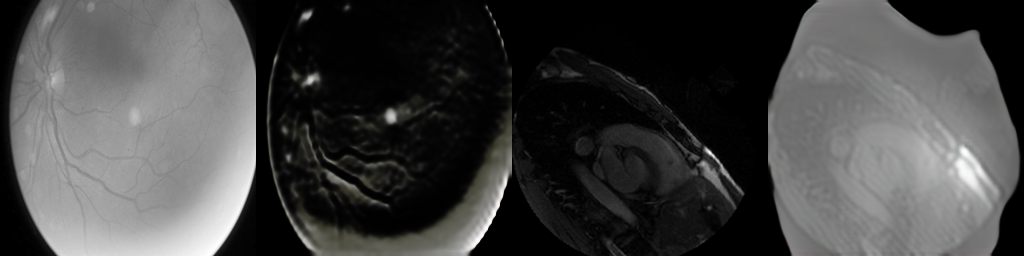

In [ ]:
img = Image.open('/content/drive/MyDrive/AI/Data/CycleGan/images/0.png')
img.show()

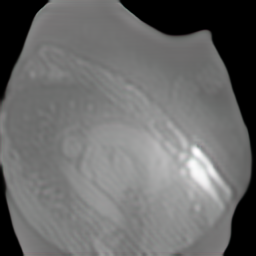

In [ ]:
image = img.crop((768, 0, 1024, 256))
image.show()

Cropping images

In [ ]:
filepath = '/content/drive/MyDrive/AI/Data/CycleGan/images/'

for filename in sorted(os.listdir(filepath)):
    if "." not in filename:
        continue
    ending = filename.split(".")[1]
    if ending not in ["jpg", "gif", "png"]:
        continue

    try:
        image = Image.open(os.path.join(filepath, filename))
    except IOError as e:
        print("Problem Opening", filepath, ":", e)
        continue

    image = image.crop((768, 0, 1024, 256))
    image = np.array(image)  # <class 'numpy.ndarray'>

    # Greyscale
  #  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Blur
  #  blur = cv2.GaussianBlur(gray, (3, 3), 0)
    # Threshold
  #  thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise and invert image
  #  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  #  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)


    name, extension = os.path.splitext(filename)
    print(name + '_cropped.png')
 #   cv2.imwrite(os.path.join('/content/drive/MyDrive/AI/Data/cyclecroping', name + '_cropped.png'),)
    path = os.path.join('/content/drive/MyDrive/AI/Data/cycle', name + '_cropped.png')
    cv2.imwrite(path, image)

Streaming output truncated to the last 5000 lines.
2941_cropped.png
2942_cropped.png
2943_cropped.png
2945_cropped.png
2946_cropped.png
2947_cropped.png
2948_cropped.png
2950_cropped.png
2952_cropped.png
2953_cropped.png
2954_cropped.png
2955_cropped.png
2956_cropped.png
2957_cropped.png
2958_cropped.png
2959_cropped.png
296_cropped.png
2960_cropped.png
2962_cropped.png
2964_cropped.png
2965_cropped.png
2966_cropped.png
2968_cropped.png
297_cropped.png
2971_cropped.png
2972_cropped.png
2973_cropped.png
2975_cropped.png
2976_cropped.png
2977_cropped.png
2979_cropped.png
2980_cropped.png
2982_cropped.png
2983_cropped.png
2984_cropped.png
2988_cropped.png
2989_cropped.png
299_cropped.png
2991_cropped.png
2992_cropped.png
2993_cropped.png
2995_cropped.png
2998_cropped.png
3_cropped.png
300_cropped.png
3000_cropped.png
3001_cropped.png
3002_cropped.png
3004_cropped.png
3007_cropped.png
3008_cropped.png
301_cropped.png
3010_cropped.png
3011_cropped.png
3012_cropped.png
3013_cropped.png
3014_

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/AI/Data/cycle')))

9584


Demographic data

In [4]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/AI/Data/demo/Final_Demographic.csv')
data.head()

Unnamed: 0  Participant ID     Sex  Age Ever had diabetes  heart rate  \
0           0         1000219  Female   59                No         NaN   
1           1         1000420    Male   61                No         NaN   
2           2         1000596  Female   44                No        71.0   
3           3         1000876  Female   68               Yes        67.0   
4           4         1000966    Male   54                No         NaN   

  Vascular/heart problems diagnosed by doctor Glucose Smoking status  \
0                         High blood pressure       2        Current   
1                           None of the above       1          Never   
2                           None of the above       1          Never   
3                           None of the above       1          Never   
4                         High blood pressure       1          Never   

   LV end diastolic volume  Oxygen rate  Diastolic blood pressure  \
0                      NaN         98.6                      93.0   
1                      NaN         98.6                      75.0   
2                    133.0         98.6                      89.0   
3                      NaN         98.6                       NaN   
4                      NaN         98.1                      70.0   

   Systolic blood pressure  
0                    144.0  
1                    141.0  
2                    131.0  
3                      NaN  
4                    116.0

63657 instance for 13 feature

In [5]:
data.shape

(63657, 13)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63657 entries, 0 to 63656
Data columns (total 13 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Unnamed: 0                                   63657 non-null  int64  
 1   Participant ID                               63657 non-null  int64  
 2   Sex                                          63657 non-null  object 
 3   Age                                          63657 non-null  int64  
 4   Ever had diabetes                            63657 non-null  object 
 5   heart rate                                   10792 non-null  float64
 6   Vascular/heart problems diagnosed by doctor  63619 non-null  object 
 7   Glucose                                      60292 non-null  object 
 8   Smoking status                               63619 non-null  object 
 9   LV end diastolic volume                      12343 non-null  float64
 10

precentage of missing values

In [7]:
print(round((data.isna().sum()/len(data.index))*100, 2))

Unnamed: 0                                      0.00
Participant ID                                  0.00
Sex                                             0.00
Age                                             0.00
Ever had diabetes                               0.00
heart rate                                     83.05
Vascular/heart problems diagnosed by doctor     0.06
Glucose                                         5.29
Smoking status                                  0.06
LV end diastolic volume                        80.61
Oxygen rate                                    94.37
Diastolic blood pressure                       56.13
Systolic blood pressure                        56.14
dtype: float64


In [8]:
data.describe(include=['O'])

Sex Ever had diabetes Vascular/heart problems diagnosed by doctor  \
count    63657             63657                                       63619   
unique       2                 4                                          17   
top     Female                No                           None of the above   
freq     36165             59290                                       48296   

       Glucose Smoking status  
count    60292          63619  
unique       5              4  
top          1          Never  
freq     53730          36812

mapping string to prepare it for modeling

In [9]:
data.replace({'Sex':{'Male':0,'Female':1},#column1
              #Column2
              'Ever had diabetes':{'No':0,'Yes':1,'Do not know':2,'Prefer not to answer':3},
              #Column3
              'Smoking status':{'Current':0,'Never':1,'Previous':2,'Prefer not to answer':3},
              #Column4
              'Glucose':{'Manual':0,'1':1,'2':2,'3':3,'4':4},
              #Column5
              'Vascular/heart problems diagnosed by doctor':{'High blood pressure':0,
              'None of the above':1,'Stroke':2,'Heart attack|Angina|High blood pressure':3,
              'Heart attack|Stroke|High blood pressure':4,
              'Angina':5,'Heart attack|High blood pressure':6,
              'Angina|High blood pressure':7,'Heart attack|Angina':8,'Stroke|High blood pressure':9,
              'Heart attack':10,'Heart attack|Stroke':11,'Heart attack|Angina|Stroke':12,
              'Prefer not to answer':13,'Angina|Stroke|High blood pressure':14,
              'Heart attack|Angina|Stroke|High blood pressure':15,'Angina|Stroke':16}}, inplace=True)

In [10]:
A=data[data['LV end diastolic volume'].isnull()].index.tolist()

In [11]:
data.drop(A[:33657], axis=0, inplace=True)
data.shape

(30000, 13)

In [12]:
print(round((data.isna().sum()/len(data.index))*100, 2))

Unnamed: 0                                      0.00
Participant ID                                  0.00
Sex                                             0.00
Age                                             0.00
Ever had diabetes                               0.00
heart rate                                     83.36
Vascular/heart problems diagnosed by doctor     0.06
Glucose                                         5.47
Smoking status                                  0.06
LV end diastolic volume                        58.86
Oxygen rate                                    97.61
Diastolic blood pressure                       81.95
Systolic blood pressure                        81.95
dtype: float64


Handling missing values

In [13]:
LVmean = data['LV end diastolic volume'].mean().round()
HeartRateMean = data['heart rate'].mean().round()
OxygenRateMean = data['Oxygen rate'].mean().round()
DiastolicBPMean = data['Diastolic blood pressure'].mean().round()
SystolicMean = data['Systolic blood pressure'].mean().round()
#MODE+VALUES
H_ProblemsMode = data['Vascular/heart problems diagnosed by doctor'].mode()
GlucoseMode = data['Glucose'].mode()
SmokingMode = data['Smoking status'].mode()
print('Mean Values:',LVmean, HeartRateMean, OxygenRateMean, DiastolicBPMean, SystolicMean)
print('Mode Values:',H_ProblemsMode,'\n',GlucoseMode,'\n',SmokingMode)

Mean Values: 140.0 72.0 98.0 82.0 140.0
Mode Values: 0    1.0
Name: Vascular/heart problems diagnosed by doctor, dtype: float64 
 0    1.0
Name: Glucose, dtype: float64 
 0    1.0
Name: Smoking status, dtype: float64


In [14]:
data.fillna({'LV end diastolic volume':LVmean,'heart rate':HeartRateMean,
                    'Oxygen rate':OxygenRateMean,'Diastolic blood pressure':DiastolicBPMean,
                   'Systolic blood pressure':SystolicMean}, inplace= True)

In [15]:
data.fillna({'Glucose':1.0,'Vascular/heart problems diagnosed by doctor':1.0,
            'Smoking status':1.0},inplace= True)

In [16]:
data.isna().sum()

Unnamed: 0                                     0
Participant ID                                 0
Sex                                            0
Age                                            0
Ever had diabetes                              0
heart rate                                     0
Vascular/heart problems diagnosed by doctor    0
Glucose                                        0
Smoking status                                 0
LV end diastolic volume                        0
Oxygen rate                                    0
Diastolic blood pressure                       0
Systolic blood pressure                        0
dtype: int64

## No duplicates

In [17]:
data.duplicated().sum()

0

## droping unnecessary columns

In [18]:
data=data.reset_index()
data.drop(['index','Unnamed: 0','Participant ID'],axis=1,inplace=True)
data.head()

Sex  Age  Ever had diabetes  heart rate  \
0    1   44                  0        71.0   
1    0   62                  0        72.0   
2    1   48                  0        72.0   
3    0   56                  0        72.0   
4    0   48                  0        72.0   

   Vascular/heart problems diagnosed by doctor  Glucose  Smoking status  \
0                                          1.0      1.0             1.0   
1                                          1.0      1.0             1.0   
2                                          1.0      1.0             1.0   
3                                          1.0      1.0             2.0   
4                                          1.0      1.0             2.0   

   LV end diastolic volume  Oxygen rate  Diastolic blood pressure  \
0                    133.0         98.6                      89.0   
1                    114.0         97.5                      85.0   
2                    112.0         97.5                      70.0   
3                    166.0         97.5                      59.0   
4                    177.0         97.5                      77.0   

   Systolic blood pressure  
0                    131.0  
1                    131.0  
2                    156.0  
3                     98.0  
4                    157.0

LV increases slightly with increasing age

In [ ]:
import plotly.express as px
fig = px.scatter(data, x="LV end diastolic volume", y="Age",color='Smoking status',symbol='Sex')
fig.show()

LV increases significantly when heart rate is at 72 and generally increases when the heart rate is low



In [ ]:
fig = px.scatter(data, x="LV end diastolic volume", y="heart rate",color='Smoking status')
fig.show()

LV increases significantly when oxygen rate is at 98

In [ ]:
fig = px.scatter(data, x="LV end diastolic volume", y="Oxygen rate",color='Smoking status',symbol='Sex')
fig.show()

LV increases significantly when Diastolic blood pressure is between 70 and 100


In [ ]:
fig = px.scatter(data, x="LV end diastolic volume", y="Diastolic blood pressure",color='Smoking status',symbol='Sex')
fig.show()

LV increases significantly when Systolic blood pressure is at 140

In [ ]:
fig = px.scatter(data, x="LV end diastolic volume", y="Systolic blood pressure",color='Smoking status',symbol='Sex')
fig.show()

Correlation

In [ ]:
corr=data.corr()
fig = px.imshow(corr, text_auto=True,width=1000, height=1000)
fig.show()

# Second model, train ML,DL Models to predict lv

In [ ]:
X=data.drop('LV end diastolic volume',axis=1)
y=data['LV end diastolic volume']

Feature selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
ex=ExtraTreesClassifier()
ex.fit(X,y)

ExtraTreesClassifier()

In [ ]:
ex.feature_importances_

array([0.00486253, 0.1916834 , 0.01289401, 0.15006035, 0.05012381,
       0.03362094, 0.03502795, 0.03169696, 0.23177598, 0.25825408])

Systolic blood pressure, diastolic blood pressure, age and heart rate are the most effective features on LV

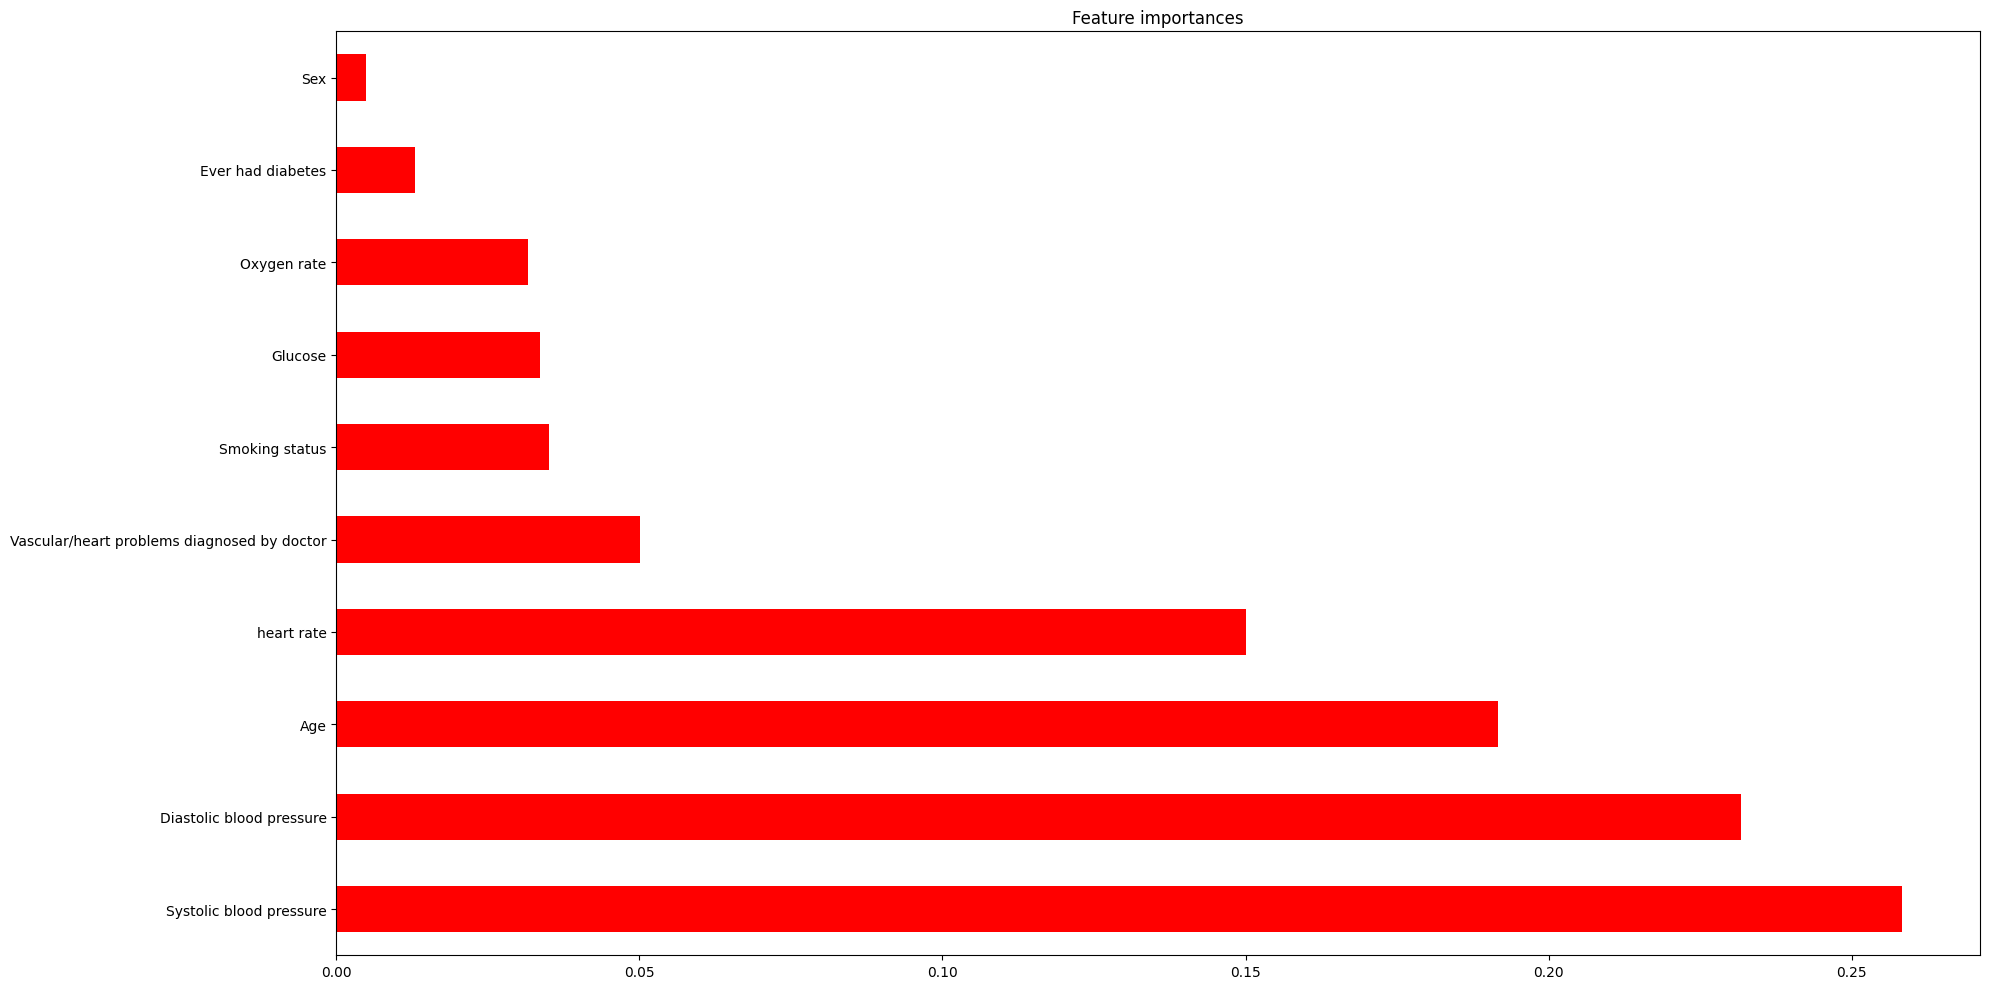

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.title('Feature importances')
feat=pd.Series(ex.feature_importances_,index=X.columns)
feat.nlargest(10).plot(kind='barh', color="r", align="center")
plt.tight_layout()
plt.grid(False)
plt.show()


splitting

In [ ]:
from sklearn.model_selection import train_test_split ,cross_val_score,RandomizedSearchCV
X_train ,X_test,y_train ,y_test =train_test_split(X,y,test_size =.2 , random_state=42 )

scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression ,SGDRegressor,Lasso,Ridge,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from xgboost.sklearn import XGBRegressor

ML models

In [ ]:
models = {'Linear Regression': LinearRegression(),
         'Lasso': Lasso(),
         'Decision Tree': DecisionTreeRegressor(),
         'Random Forest': RandomForestRegressor(),
         'Gradient Boosting':GradientBoostingRegressor(),
         'Ridge': Ridge(),
         'Stochastic Gradien Descent': SGDRegressor(),
         'Elastic': ElasticNet(),
         'xgb Regressor': XGBRegressor()}

function for training a model

In [ ]:
def fit_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                            scoring='mean_squared_error',
                                            cv=3
                                            ).mean()

    return model_scores

Lasso win

In [ ]:
model_scores = fit_score(models,X_train,X_test,y_train,y_test)

model_scores

{'Linear Regression': -2610.3894521054713,
 'Lasso': -2609.7453911592124,
 'Decision Tree': -3519.2791254632434,
 'Random Forest': -3012.169119263,
 'Gradient Boosting': -2643.6030550519886,
 'Ridge': -2610.387829822739,
 'Stochastic Gradien Descent': -2612.045723590016,
 'Elastic': -2614.5742826760397,
 'xgb Regressor': -3205.1771129981175}

hyperparameter tunning

In [ ]:
np.random.seed(42)
params={
        'alpha':[0,0.01,0.1,1],
        'max_iter':[50,100,500,1000.2000]
       }
lass = RandomizedSearchCV(Lasso(),
                                param_distributions=params,
                                cv=3,
                                n_iter=30,
                                verbose=0,
                                n_jobs=-1
                               )

lass.fit(X_train, y_train)

lass.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 16 is smaller than n_iter=30. Running 16 iterations. For exhaustive searches, use GridSearchCV.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


12 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py", 

{'max_iter': 50, 'alpha': 1}

In [ ]:
model1=Lasso(max_iter=50,alpha=1)
model1.fit(X_train,y_train)

Lasso(alpha=1, max_iter=50)

In [ ]:
y_pred1 = model1.predict(X_test)

voting regressor

In [ ]:
vot=VotingRegressor([('LinearRegression',LinearRegression()),('DecisionTrees',DecisionTreeRegressor()),('LassoRegression',Lasso()),
                     ('RandomForest',RandomForestRegressor()),('ElasticNet',ElasticNet()),
                     ('StochasticGradientDescent',SGDRegressor()),
                    ('GrafientBoosting',GradientBoostingRegressor()),('Ridge',Ridge()),('xgb',XGBRegressor())])
vot.fit(X_train,y_train)
y_pred1=vot.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred1)

2644.858144543946

Dl models

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [ ]:
model = Sequential()

# The Input Layer :
model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166,273
Trainable params: 166,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/1000
1197/1200 [============================>.] - ETA: 0s - loss: 18.5902 - mean_absolute_error: 18.5902
Epoch 1: val_loss improved from inf to 13.47018, saving model to Weights-001--13.47018.hdf5
1200/1200 [==============================] - 10s 3ms/step - loss: 18.5817 - mean_absolute_error: 18.5817 - val_loss: 13.4702 - val_mean_absolute_error: 13.4702
Epoch 2/1000
1197/1200 [============================>.] - ETA: 0s - loss: 13.3817 - mean_absolute_error: 13.3817
Epoch 2: val_loss improved from 13.47018 to 12.66440, saving model to Weights-002--12.66440.hdf5
1200/1200 [==============================] - 4s 3ms/step - loss: 13.3721 - mean_absolute_error: 13.3721 - val_loss: 12.6644 - val_mean_absolute_error: 12.6644
Epoch 3/1000
1186/1200 [============================>.] - ETA: 0s - loss: 13.2520 - mean_absolute_error: 13.2520
Epoch 3: val_loss improved from 12.66440 to 12.14248, saving model to Weights-003--12.14248.hdf5
1200/1200 [==============================] - 4s 3ms/step

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 0s 1ms/step


In [ ]:
input_path='/content/drive/MyDrive/AI/Data/cycle/'

In [ ]:
import os
print(len(os.listdir('/content/drive/MyDrive/AI/Data/cycle/train')))

8259


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/AI/Data/cycle/val')))

1325


# Third model, use demographic data and cycle gan output "cmr" to predict lv





In [ ]:
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/AI/Data/cycle/")


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
batch_size = 32
img_height = 256
img_width = 256
train = image_dataset_from_directory(data_dir,
                                        seed = 42,
                                        image_size=(img_height, img_width),
                                        validation_split=0.2,
                                        subset='training')

Found 9584 files belonging to 2 classes.
Using 7668 files for training.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerCon

In [ ]:
val = image_dataset_from_directory(data_dir,
                                      seed = 42,
                                      image_size=(img_height, img_width),
                                      validation_split=0.2,
                                      subset='validation',)

Found 9584 files belonging to 2 classes.
Using 1916 files for validation.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in d

In [ ]:
input_shape=(256,256,3)
batch_size=32

In [ ]:
from tensorflow.keras.applications import ResNet50
res = ResNet50(weights = "imagenet", include_top = False, input_shape=(256,256,3))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in

In [ ]:
for layer in res.layers[:121]:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential,regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization

In [ ]:
model = Sequential()
model.add(res)
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128,activation= "linear",kernel_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "linear"))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 2048)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 2048)       8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss='mean_squared_error',
    metrics=['mse']
)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device

In [ ]:
from tensorflow import keras
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3,verbose=1)

In [ ]:
history = model.fit(
    train,
    validation_data = val,
    epochs = 5,
    callbacks = callback
)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity i

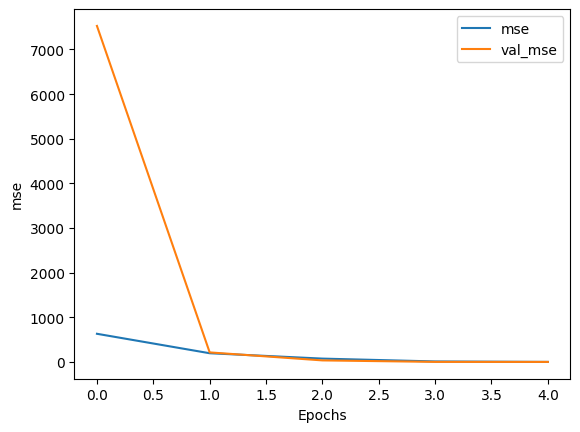

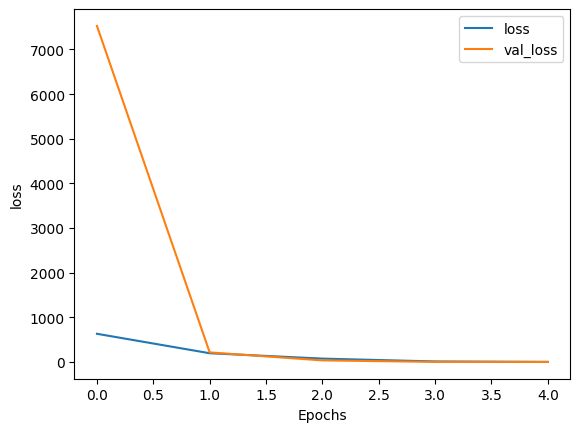

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


plot_graphs(history, "mse")
plot_graphs(history, "loss")

In [ ]:
preformance = model.evaluate(val)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity i

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

## concat lv and cmr images

In [ ]:
image_dir=Path("/content/drive/MyDrive/AI/Data/cycle/")
filepaths = pd.Series(list(image_dir.glob(r'**/*.png')), name='Filepath').astype(str)

In [ ]:
dataset=os.listdir('/content/drive/MyDrive/AI/Data/cycle/')
class_labels = []

for item in dataset:

 all_classes = os.listdir('/content/drive/MyDrive/AI/Data/cycle/' + '/' +item+'/')
 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))


In [ ]:
df = pd.DataFrame(data=class_labels, columns=['Kind', 'Image'])
df.head()

Kind                                Image
0  train  dataset_path/train/8423_cropped.png
1  train  dataset_path/train/8424_cropped.png
2  train  dataset_path/train/8425_cropped.png
3  train  dataset_path/train/8426_cropped.png
4  train  dataset_path/train/8428_cropped.png

In [ ]:
final=pd.concat([df,data],axis=1)
final.head()

Kind                                Image  Participant ID  Sex  Age  \
0  train  dataset_path/train/8423_cropped.png         1000596    1   44   
1  train  dataset_path/train/8424_cropped.png         1001797    0   62   
2  train  dataset_path/train/8425_cropped.png         1003366    1   48   
3  train  dataset_path/train/8426_cropped.png         1003996    0   56   
4  train  dataset_path/train/8428_cropped.png         1004621    0   48   

   Ever had diabetes  heart rate  Vascular/heart problems diagnosed by doctor  \
0                  0        71.0                                          1.0   
1                  0        72.0                                          1.0   
2                  0        72.0                                          1.0   
3                  0        72.0                                          1.0   
4                  0        72.0                                          1.0   

   Glucose  Smoking status  LV end diastolic volume  Oxygen rate  \
0      1.0             1.0                    133.0         98.6   
1      1.0             1.0                    114.0         97.5   
2      1.0             1.0                    112.0         97.5   
3      1.0             2.0                    166.0         97.5   
4      1.0             2.0                    177.0         97.5   

   Diastolic blood pressure  Systolic blood pressure  
0                      89.0                    131.0  
1                      85.0                    131.0  
2                      70.0                    156.0  
3                      59.0                     98.0  
4                      77.0                    157.0

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Kind                                         9584 non-null   object 
 1   Image                                        9584 non-null   object 
 2   Participant ID                               30000 non-null  int64  
 3   Sex                                          30000 non-null  int64  
 4   Age                                          30000 non-null  int64  
 5   Ever had diabetes                            30000 non-null  int64  
 6   heart rate                                   30000 non-null  float64
 7   Vascular/heart problems diagnosed by doctor  30000 non-null  float64
 8   Glucose                                      30000 non-null  float64
 9   Smoking status                               30000 non-null  float64
 10

In [ ]:
final.dropna(inplace=True)

In [ ]:
final.shape

(9584, 14)

In [ ]:
df1= pd.concat([filepaths, final['LV end diastolic volume']], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
df1.head()

Filepath  LV end diastolic volume
0  /content/drive/MyDrive/AI/Data/cycle/train/550...                    120.0
1  /content/drive/MyDrive/AI/Data/cycle/val/1095_...                    140.0
2  /content/drive/MyDrive/AI/Data/cycle/train/990...                    138.0
3  /content/drive/MyDrive/AI/Data/cycle/train/138...                    125.0
4  /content/drive/MyDrive/AI/Data/cycle/val/1493_...                    140.0

In [ ]:
df1.shape

(9584, 2)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df1, train_size=0.8, shuffle=True, random_state=42)

Data augmentation

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_df

Filepath  \
3651  /content/drive/MyDrive/AI/Data/cycle/train/106...   
8823  /content/drive/MyDrive/AI/Data/cycle/val/1529_...   
2847  /content/drive/MyDrive/AI/Data/cycle/train/485...   
1017  /content/drive/MyDrive/AI/Data/cycle/train/836...   
4961  /content/drive/MyDrive/AI/Data/cycle/train/103...   
...                                                 ...   
5734  /content/drive/MyDrive/AI/Data/cycle/train/902...   
5191  /content/drive/MyDrive/AI/Data/cycle/train/220...   
5390  /content/drive/MyDrive/AI/Data/cycle/train/735...   
860   /content/drive/MyDrive/AI/Data/cycle/train/876...   
7270  /content/drive/MyDrive/AI/Data/cycle/val/620_c...   

      LV end diastolic volume  
3651                    142.0  
8823                    140.0  
2847                    135.0  
1017                    210.0  
4961                    140.0  
...                       ...  
5734                    158.0  
5191                    143.0  
5390                    164.0  
860                     146.0  
7270                    140.0  

[7667 rows x 2 columns]

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='LV end diastolic volume',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='LV end diastolic volume',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='LV end diastolic volume',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 6134 validated image filenames.
Found 1533 validated image filenames.
Found 1917 validated image filenames.


training first model - CNN

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in d

Root mean squared error = 56 for first try, not bad

In [ ]:
predicted_lv = np.squeeze(model.predict(test_images))
true_lv = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_lv, predicted_lv)
print("Test R^2 Score: {:.5f}".format(r2))


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableO

null hypothesis = 53.8

In [ ]:
null_rmse = np.sqrt(np.sum((true_lv - np.mean(true_lv))**2) / len(true_lv))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 53.81598


Second model , resnet 50

In [ ]:
from tensorflow.keras.applications import ResNet50
res = ResNet50(weights = "imagenet", include_top = False, input_shape=(224,224,3))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in

In [ ]:
for layer in res.layers[:121]:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(res)
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256,activation= "linear"))
model.add(Dropout(0.2))
model.add(Dense(64,activation= "linear",kernel_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 2048)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 2048)       8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mean_squared_error']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Streaming output truncated to the last 5000 lines.
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/de

Root mean squared error = 54 for second try

In [ ]:
predicted_lvv = np.squeeze(model.predict(test_images))
true_lvv = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableO

In [ ]:
print(rmse)

[54.0103456  54.01034108]


In [ ]:
tf.keras.activations.linear(predicted_lvv)

array([124.9527 , 123.055  , 140.93271, ..., 140.32996, 140.32271,
       135.182  ], dtype=float32)

hyperparameter tunning

In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 12.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
def model_constructor(hp):
    model_tune = Sequential()
    #Input
    model_tune.add(Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)))
    model_tune.add(MaxPooling2D((3,3)))
    model_tune.add(BatchNormalization())


    # The number of filters is going to be a variable in this case
    hp_units = hp.Int('units', min_value=16, max_value=64, step=16)

    hp_padding = hp.Choice('padding', values=['same', 'valid'])

    # Layer 2
    model_tune.add(Conv2D(hp_units, (3,3), padding=hp_padding, activation='relu',kernel_regularizer=keras.regularizers.l2(1e-5)))
    model_tune.add(BatchNormalization())

    # Layer 3
    model_tune.add(Conv2D(hp_units, (3,3), padding=hp_padding, activation='relu',kernel_regularizer=keras.regularizers.l2(1e-4)))
    model_tune.add(MaxPooling2D((3,3)))
    model_tune.add(Dropout(0.25))
    model_tune.add(BatchNormalization())

    # Layer 4
    model_tune.add(Conv2D(hp_units, (3,3), padding=hp_padding, activation='relu',kernel_regularizer=keras.regularizers.l2(1e-3)))
    model_tune.add(BatchNormalization())

    # Layer 5
    model_tune.add(Conv2D(hp_units, (3,3), padding=hp_padding, activation='relu',kernel_regularizer=keras.regularizers.l2(1e-2)))
    model_tune.add(Dropout(0.2))
    model_tune.add(BatchNormalization())


    # Layer 6
    model_tune.add(Conv2D(64, (3,3), padding=hp_padding, activation=None))
    model_tune.add(MaxPooling2D((3,3)))
    model_tune.add(BatchNormalization())
    # Flatten layer
    model_tune.add(Flatten())

    # Output layer
    model_tune.add(Dense(1, activation='linear'))

    # The number of the learning rate is going to be a variable in this case
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    model_tune.compile(optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate), loss = 'mse', metrics=['mse'])

    return model_tune

In [ ]:
from tensorflow import keras
tunner = kt.Hyperband(
    model_constructor,
    objective = 'val_loss',
    max_epochs=5,
    factor=2,
)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing o

In [ ]:
tunner.search(
    train_images,
    validation_data=val_images,
    epochs=10,
)

best_hps = tunner.get_best_hyperparameters(num_trials=1)[0]

Trial 21 Complete [00h 02m 49s]
val_loss: 4017.1474609375

Best val_loss So Far: 3928.966796875
Total elapsed time: 00h 33m 34s


In [ ]:
print('The Hyperparameters that give the highest accuracy are:')

print(f"Units: {best_hps.get('units')}")

print(f"Learining rate: {best_hps.get('learning_rate')}")

The Hyperparameters that give the highest accuracy are:
Units: 32
Learining rate: 0.01


In [ ]:
hypermodel = tunner.hypermodel.build(best_hps)

hypermodel.summary()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing o

In [ ]:
history_hypermodel = hypermodel.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks =[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
            )
        ]
)

Streaming output truncated to the last 5000 lines.
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_215035 in device /job:localhost/replica:0/task:0/device:GPU:0
166/192 [========================>.....] - ETA: 3s - loss: 12328.4590 - mse: 12325.9824Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_215035 in device /job:localhost/replica:0/task:0/device:GPU:0
167/192 [=========================>....] - ETA: 3s - loss: 12260.6211 - mse: 12258.1436Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_215035 in device /job:localhost/replica:0/task:0/device:GPU:0
168/192 [=========================>....] - ETA: 3s - loss: 12191.8896 - 

In [ ]:
predicted_lvvv = np.squeeze(hypermodel.predict(test_images))
true_lvvv = test_images.labels

rmse = np.sqrt(hypermodel.evaluate(test_images, verbose=0))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableO

Root mean squared error = 53.9, fantastic!

In [ ]:
print(rmse)

[53.90180462 53.87487765]


In [ ]:
tf.keras.activations.linear(predicted_lvvv)

array([133.85178, 134.22733, 138.8691 , ..., 141.14021, 134.88995,
       139.11646], dtype=float32)

For the first three percentages, the risk of a heart attack increases gradually with the gradual increase in the size of the left ventricle, then it rises to reach 51% when the size of the ventricle increases significantly.

In [ ]:
from scipy import  stats
[stats.percentileofscore(predicted_lvvv, a, 'mean') for a in predicted_lvvv]

[5.294731351069379,
 7.48565466875326,
 51.617110067814295,
 54.5905059989567,
 77.33437663015128,
 62.936880542514345,
 84.3244653103808,
 27.30829420970266,
 41.992696922274384,
 14.893062076160668,
 40.245174752217004,
 29.447052686489304,
 68.41418883672405,
 24.856546687532603,
 2.477829942618675,
 37.16744913928012,
 87.08920187793427,
 19.3792383933229,
 34.141888367240476,
 62.25873761085028,
 9.624413145539906,
 1.1737089201877935,
 17.70996348461137,
 42.33176838810642,
 77.90818988002087,
 15.727699530516432,
 94.9660928534168,
 48.59154929577465,
 51.147626499739175,
 32.88993218570683,
 28.76890975482525,
 19.953051643192488,
 53.02556077203965,
 5.920709441836202,
 20.631194574856547,
 34.55920709441836,
 4.199269692227438,
 22.091810119979133,
 3.4689619196661448,
 33.62023995826813,
 16.666666666666668,
 98.77412623891497,
 40.81898800208659,
 96.53103808033386,
 35.811163275952005,
 7.798643714136672,
 4.460093896713615,
 91.67970787689097,
 45.35732916014606,
 84.6374

In [1]:
print("yalahwi")

yalahwi
